## Funções Auxiliares

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression

sns.set_theme(color_codes=True)

In [11]:
uf_regiao = {
  'BR': 'Brasil',
  'RO': 'Norte',
	'AC': 'Norte',
	'AM': 'Norte',
	'RR': 'Norte',
	'PA': 'Norte',
	'AP': 'Norte',
	'TO': 'Norte',
 	'MA': 'Nordeste',
	'PI': 'Nordeste',
	'CE': 'Nordeste',
	'RN': 'Nordeste',
	'PB': 'Nordeste',
	'PE': 'Nordeste',
	'AL': 'Nordeste',
	'SE': 'Nordeste',
	'BA': 'Nordeste',
	'MG': 'Sudeste',
	'ES': 'Sudeste',
	'RJ': 'Sudeste',
	'SP': 'Sudeste',
	'PR': 'Sul',
	'SC': 'Sul',
	'RS': 'Sul',
	'MS': 'Centro-Oeste',
	'MT': 'Centro-Oeste',
	'GO': 'Centro-Oeste',
	'DF': 'Centro-Oeste',
}

In [12]:
def linreg_plot(x, y):
  sns.regplot(
    x=x, y=y,
    order=1, ci=None,
    scatter_kws={"s": 80})

In [13]:
def plot_scatter(df):
  p = sns.scatterplot(
		x='angle', y='intercept',
		hue='regiao', data=df,
	)
  p.set(
    xlim=(-.8, .8),
    ylim=(-.1, 1.1),
  )
  p.legend(loc='lower left')
  return p

In [14]:
def get_linreg_params(x, y):
	reg = LinearRegression().fit(x, y)
	angle = reg.coef_[0][0]
	intercept = reg.intercept_[0]
	return angle, intercept

In [15]:
def get_ano_partos(df, uf=None):
  cols = [uf] if uf else df.columns
  df = pd.DataFrame(
    df[cols].sum(axis=1)[1:-1],
    columns=['partos']
  ).reset_index(level=0)
  ano = np.linspace(
    0, 1, len(df['ano'])
  ).reshape(-1, 1)[::-1]
  partos = normalize(
    df['partos'].array.reshape(-1, 1),
    norm='max',
    axis=0)
  return ano, partos

In [16]:
def get_params_per_uf(df):
  inputs = list()
  ufs = np.append(df.columns, [None])
  for uf in ufs:
    ano, partos = get_ano_partos(df, uf)
    d = {'uf' : uf if uf else 'BR'}
    d['regiao'] = uf_regiao[d['uf']]
    d['angle'], d['intercept'] = (
      get_linreg_params(ano, partos))
    inputs.append(d)
  return pd.DataFrame(inputs)

## Todos partos

### Ambos

In [17]:
todos_ambos = pd.read_csv('data/xz/uf_ano_ambos_.csv.xz', index_col=0)
params_todos_ambos = get_params_per_uf(todos_ambos)

<AxesSubplot:xlabel='angle', ylabel='intercept'>

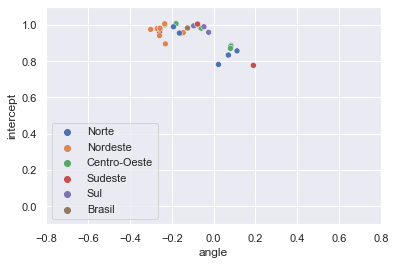

In [18]:
plot_scatter(params_todos_ambos)

### Normal

In [19]:
todos_normal = pd.read_csv('data/xz/uf_ano_normal_.csv.xz', index_col=0)
params_todos_normal = get_params_per_uf(todos_normal)

<AxesSubplot:xlabel='angle', ylabel='intercept'>

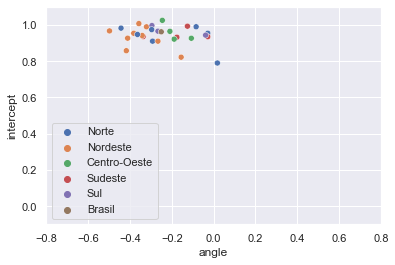

In [20]:
plot_scatter(params_todos_normal)

### Cesariano

In [21]:
todos_cesariano = pd.read_csv('data/xz/uf_ano_cesariano_.csv.xz', index_col=0)
params_todos_cesariano = get_params_per_uf(todos_cesariano)

<AxesSubplot:xlabel='angle', ylabel='intercept'>

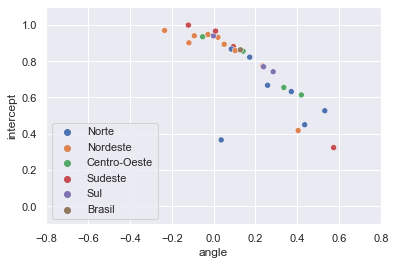

In [22]:
plot_scatter(params_todos_cesariano)

## Município diferente

### Ambos

In [23]:
municipio_ambos = pd.read_csv('data/xz/uf_ano_ambos_c1.csv.xz', index_col=0)
params_municipio_ambos = get_params_per_uf(municipio_ambos)

<AxesSubplot:xlabel='angle', ylabel='intercept'>

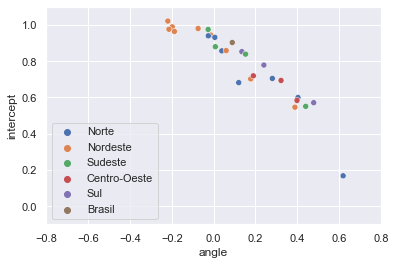

In [24]:
plot_scatter(params_municipio_ambos)

### Normal

In [25]:
municipio_normal = pd.read_csv('data/xz/uf_ano_normal_c1.csv.xz', index_col=0)
params_municipio_normal = get_params_per_uf(municipio_normal)

<AxesSubplot:xlabel='angle', ylabel='intercept'>

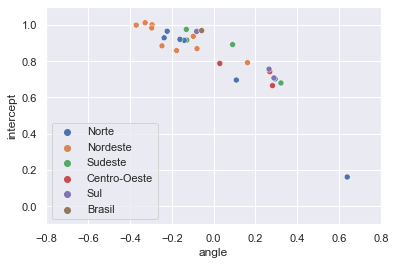

In [26]:
plot_scatter(params_municipio_normal)

### Cesariano

In [27]:
municipio_cesariano = pd.read_csv('data/xz/uf_ano_cesariano_c1.csv.xz', index_col=0)
params_municipio_cesariano = get_params_per_uf(municipio_cesariano)

<AxesSubplot:xlabel='angle', ylabel='intercept'>

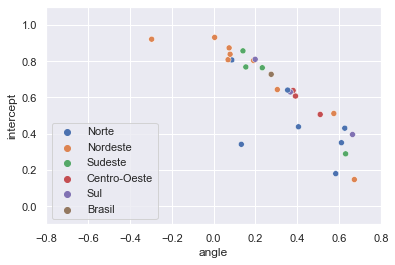

In [28]:
plot_scatter(params_municipio_cesariano)

## Região diferente

### Ambos

In [29]:
regiao_ambos = pd.read_csv('data/xz/uf_ano_ambos_c3.csv.xz', index_col=0)
params_regiao_ambos = get_params_per_uf(regiao_ambos)

<AxesSubplot:xlabel='angle', ylabel='intercept'>

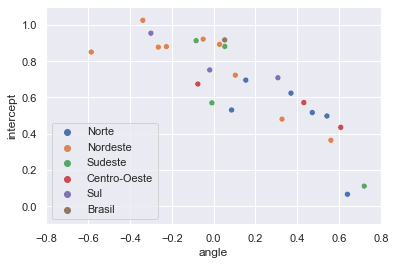

In [30]:
plot_scatter(params_regiao_ambos)

### Normal

In [31]:
regiao_normal = pd.read_csv('data/xz/uf_ano_normal_c3.csv.xz', index_col=0)
params_regiao_normal = get_params_per_uf(regiao_normal)

<AxesSubplot:xlabel='angle', ylabel='intercept'>

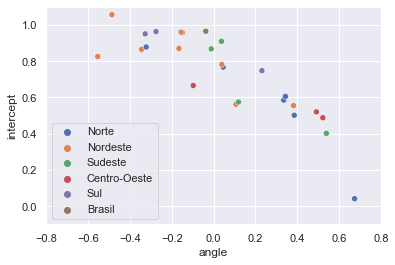

In [32]:
plot_scatter(params_regiao_normal)

### Cesariano

In [33]:
regiao_cesariano = pd.read_csv('data/xz/uf_ano_cesariano_c3.csv.xz', index_col=0)
params_regiao_cesariano = get_params_per_uf(regiao_cesariano)

<AxesSubplot:xlabel='angle', ylabel='intercept'>

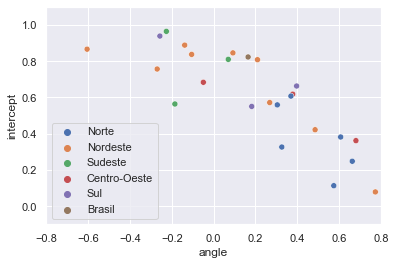

In [34]:
plot_scatter(params_regiao_cesariano)

# Agregando ambos os tipos de parto

In [38]:
def agrega_partos(cs=range(6)):
  for i in cs:
    ambos = list()
    for tipo in ['normal', 'cesariano']:
      ambos.append(pd.read_csv(
        f'data/xz/uf_ano_{tipo}_c{i}.csv.xz',
        index_col=0))
    nor, ces = ambos
    ambos = pd.DataFrame(
      nor.values + ces.values,
      columns=nor.columns,
      index=nor.index)
    ambos.to_csv(
      f'data/xz/uf_ano_ambos_c{i}.csv.xz',
    )

In [45]:
i = 6
pd.read_csv(f'data/xz/uf_ano_ambos_c{i}.csv.xz', index_col=0)

,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
ano,,,,,,,,,,,,,,,,,,,,,
2021,NaN,22.0,10.0,NaN,89.0,26.0,28.0,15.0,84.0,87.0,...,49.0,37.0,15.0,9.0,11.0,53.0,34.0,6.0,187.0,122.0
2020,8.0,62.0,29.0,7.0,228.0,81.0,118.0,45.0,325.0,237.0,...,134.0,168.0,48.0,18.0,28.0,93.0,146.0,22.0,766.0,320.0
2019,6.0,48.0,30.0,5.0,221.0,59.0,96.0,34.0,299.0,249.0,...,147.0,125.0,47.0,25.0,7.0,104.0,154.0,12.0,751.0,366.0
2018,3.0,44.0,14.0,14.0,219.0,59.0,77.0,53.0,316.0,182.0,...,127.0,120.0,34.0,35.0,9.0,79.0,123.0,27.0,755.0,442.0
2017,3.0,41.0,18.0,5.0,149.0,55.0,23.0,39.0,215.0,204.0,...,127.0,86.0,33.0,17.0,4.0,89.0,83.0,12.0,571.0,369.0
2016,4.0,28.0,20.0,6.0,127.0,38.0,31.0,61.0,221.0,212.0,...,122.0,75.0,16.0,19.0,5.0,58.0,74.0,9.0,429.0,330.0
2015,8.0,15.0,13.0,NaN,111.0,30.0,17.0,23.0,134.0,181.0,...,69.0,56.0,19.0,11.0,5.0,35.0,50.0,10.0,252.0,259.0
2014,4.0,10.0,7.0,2.0,86.0,15.0,16.0,20.0,60.0,189.0,...,67.0,28.0,6.0,7.0,4.0,33.0,25.0,5.0,127.0,233.0
2013,2.0,11.0,9.0,NaN,97.0,21.0,12.0,14.0,81.0,113.0,...,60.0,30.0,6.0,8.0,NaN,30.0,16.0,5.0,132.0,113.0
